In [1]:
import sys
sys.path.append('/home/me/phd/actual-causality/subprojects/metamorphic/case-studies/lift')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import heapq
from collections import deque, defaultdict

from search_formulation import MonotoQual, RevMonotoQual, SearchSpace, AdditiveBundle, hp_cause_bfs, hp_cause_mm, hp_cause_mm_bundled
from experiment import run_exp_individual, draw_hists

In [4]:
# using actual simulator
# from lift_simulation import LiftSimulation, run_lift_simulation_for_lifts
# simulator_func = run_lift_simulation_for_lifts

# using a mock simulator
from mock_lift_simulation import MockLiftsSimulator
mock_simulator = MockLiftsSimulator(max_time=1)
simulator_func = mock_simulator.simulate

search_space = SearchSpace(simulator_func)

In [8]:
max_num_lifts= 20
num_experiments = 10
results = [run_exp_individual(max_num_lifts, simulator_func, search_space) for _ in tqdm(range(num_experiments))]

  0%|          | 0/10 [00:00<?, ?it/s]

Initially active lifts: 11/20, initial AWT: 0.09090909090909091, aiming for: 0.08181818181818182
hp done


 10%|█         | 1/10 [00:06<00:55,  6.18s/it]

hp mm done
Initially active lifts: 10/20, initial AWT: 0.1, aiming for: 0.09000000000000001
hp done


 20%|██        | 2/10 [00:10<00:42,  5.33s/it]

hp mm done
Initially active lifts: 8/20, initial AWT: 0.125, aiming for: 0.1125
hp done


 30%|███       | 3/10 [00:11<00:23,  3.30s/it]

hp mm done
Initially active lifts: 12/20, initial AWT: 0.08333333333333333, aiming for: 0.075
hp done


 40%|████      | 4/10 [00:23<00:40,  6.78s/it]

hp mm done
Initially active lifts: 9/20, initial AWT: 0.1111111111111111, aiming for: 0.09999999999999999
hp done


 50%|█████     | 5/10 [00:28<00:30,  6.14s/it]

hp mm done
Initially active lifts: 12/20, initial AWT: 0.08333333333333333, aiming for: 0.075
hp done


 60%|██████    | 6/10 [00:32<00:21,  5.35s/it]

hp mm done
Initially active lifts: 8/20, initial AWT: 0.125, aiming for: 0.1125
hp done


 70%|███████   | 7/10 [00:33<00:11,  3.80s/it]

hp mm done
Initially active lifts: 13/20, initial AWT: 0.07692307692307693, aiming for: 0.06923076923076923
hp done


 80%|████████  | 8/10 [00:40<00:09,  4.78s/it]

hp mm done
Initially active lifts: 10/20, initial AWT: 0.1, aiming for: 0.09000000000000001
hp done


 90%|█████████ | 9/10 [00:44<00:04,  4.77s/it]

hp mm done
Initially active lifts: 13/20, initial AWT: 0.07692307692307693, aiming for: 0.06923076923076923
hp done


100%|██████████| 10/10 [00:51<00:00,  5.19s/it]

hp mm done


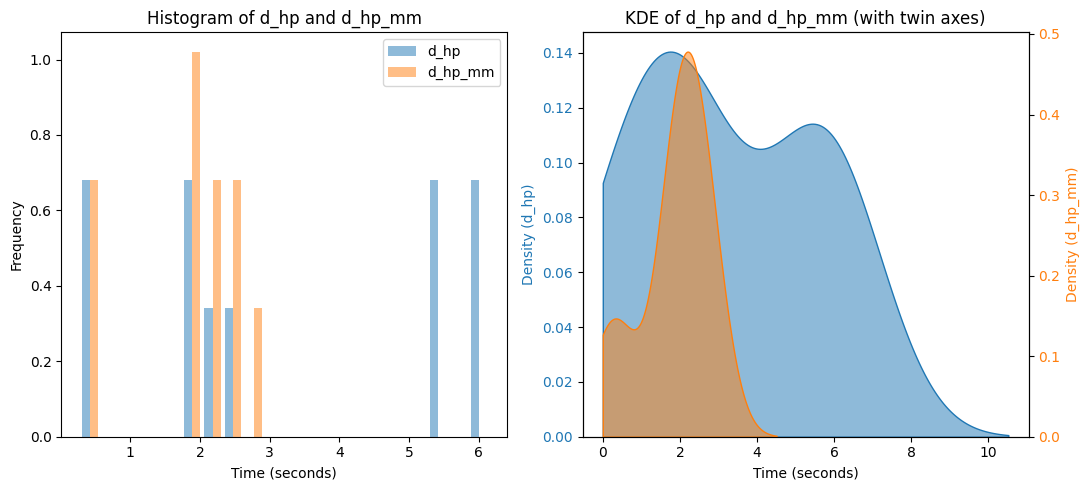

In [46]:
draw_hists(results)

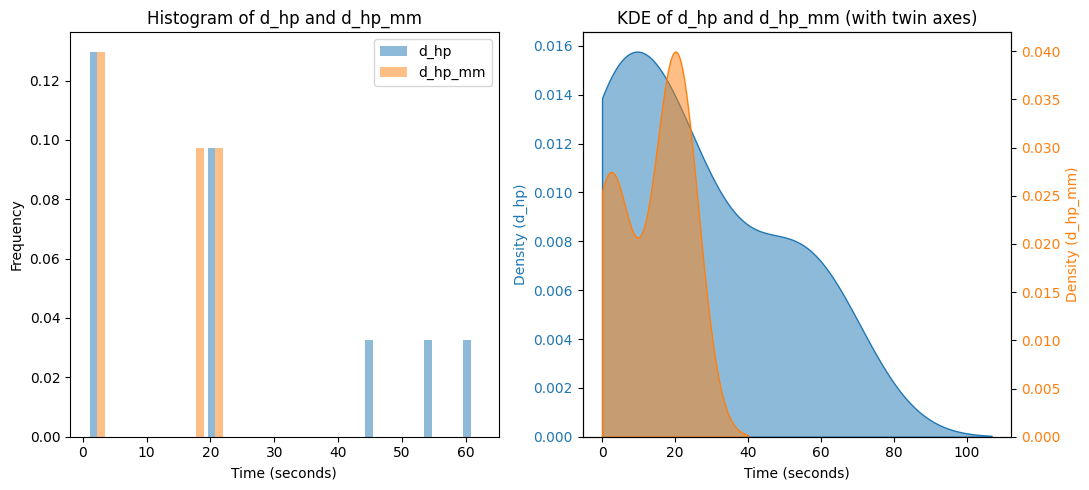

In [49]:
draw_hists(results)

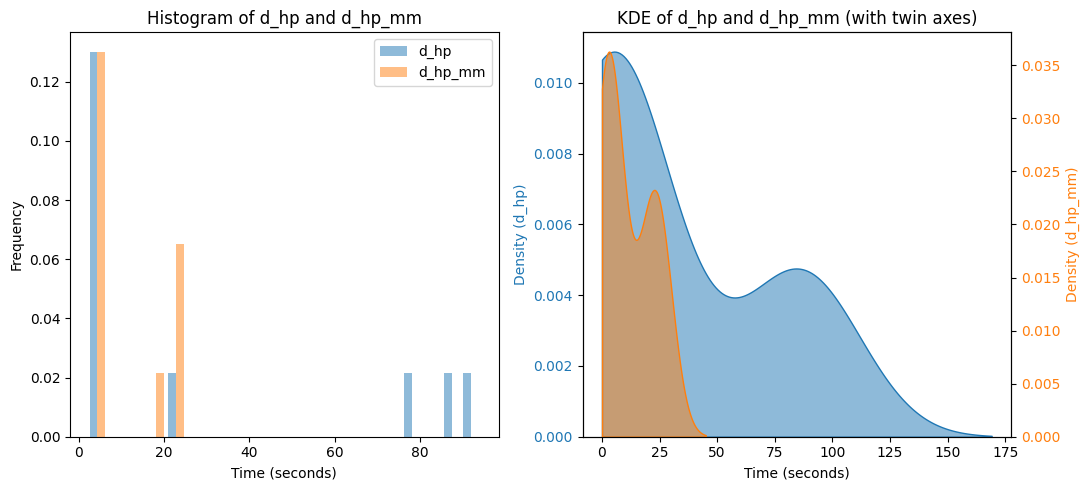

In [51]:
draw_hists(results)

In [52]:
results

[{'d_hp': 3.380948066711426, 'd_hp_mm': 3.3863837718963623},
 {'d_hp': 3.4158308506011963, 'd_hp_mm': 3.4352681636810303},
 {'d_hp': 2.1398115158081055, 'd_hp_mm': 2.1159839630126953},
 {'d_hp': 79.26398134231567, 'd_hp_mm': 25.10131573677063},
 {'d_hp': 21.268341064453125, 'd_hp_mm': 19.89402437210083},
 {'d_hp': 2.684418201446533, 'd_hp_mm': 2.68339467048645},
 {'d_hp': 2.3619019985198975, 'd_hp_mm': 2.368494749069214},
 {'d_hp': 3.3801212310791016, 'd_hp_mm': 3.3768136501312256},
 {'d_hp': 85.07878398895264, 'd_hp_mm': 24.85142421722412},
 {'d_hp': 94.26891040802002, 'd_hp_mm': 22.463997840881348}]

In [61]:
# Run experiments with N=40 and different bundle sizes
N = 40
bundle_sizes = [2, 10]
num_experiments = 5

results_bundled = []
for bundle_size in bundle_sizes:
    for _ in tqdm(range(num_experiments), desc=f"Bundle size {bundle_size}"):
        result = run_bundled_exp(N, bundle_size)
        results_bundled.append(result)

Bundle size 2:   0%|          | 0/5 [00:00<?, ?it/s]

N=40, bundle_size=2
Initially active lifts: 20/40, initial AWT: 0.1, aiming for: 0.09000000000000001
Standard A* done in 61.211s


Bundle size 2:   0%|          | 0/5 [29:32<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Analyze bundled results
import pandas as pd

df = pd.DataFrame(results_bundled)
print("\nSummary by bundle size:")
print(df.groupby('bundle_size')[['d_standard', 'd_bundled', 'speedup']].agg(['mean', 'std']))

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plot of execution times
bundle_2_standard = df[df['bundle_size'] == 2]['d_standard']
bundle_2_bundled = df[df['bundle_size'] == 2]['d_bundled']
bundle_10_standard = df[df['bundle_size'] == 10]['d_standard']
bundle_10_bundled = df[df['bundle_size'] == 10]['d_bundled']

ax1.boxplot([bundle_2_standard, bundle_2_bundled, bundle_10_standard, bundle_10_bundled],
            labels=['Standard\n(bundle=2)', 'Bundled\n(bundle=2)', 'Standard\n(bundle=10)', 'Bundled\n(bundle=10)'])
ax1.set_ylabel('Time (seconds)')
ax1.set_title('Execution Time Comparison')
ax1.grid(True, alpha=0.3)

# Bar plot of average speedup
speedup_means = df.groupby('bundle_size')['speedup'].mean()
speedup_stds = df.groupby('bundle_size')['speedup'].std()
ax2.bar(speedup_means.index.astype(str), speedup_means.values, yerr=speedup_stds.values, capsize=5)
ax2.set_xlabel('Bundle Size')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Average Speedup of Bundled vs Standard A*')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#%% --- cell (code) ---
draw_hists(results)


#%% --- cell (code) ---
draw_hists(results)
